In [1]:
import csv
import numpy as np
import pandas as pd
# import geopandas as gpd
from IPython.display import Image
# from shapely.geometry import Point, Polygon
from math import factorial
import datetime
import time
import scipy
import scipy.signal
import os, os.path

from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.linear_model import LinearRegression
from patsy import cr

# from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sb


import sys
start_time = time.time()

/Users/hn/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
sys.path.append('/Users/hn/Documents/00_GitHub/Ag/remote_sensing/python/')

import remote_sensing_core as rc
import remote_sensing_plot_core as rcp

data_dir = "/Users/hn/Documents/01_research_data/remote_sensing/test_Aeolus_data/"
f_name = "01_Regular_filledGap_Grant_SF_2017_EVI.csv"

In [15]:
eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

indeks = "EVI"
# irrigated_only = 1
# SF_year = 2017

given_county = "Grant"

# jumps = sys.argv[1]
# indeks = sys.argv[2]
# irrigated_only = int(sys.argv[3])
# SF_year = int(sys.argv[4])
# given_county = sys.argv[5]
# regularized = True
SF_year = 2017
sos_thresh = 0.3
eos_thresh = 0.3
minFinderDetla = 0.4

In [16]:
a_df = pd.read_csv(data_dir + f_name, low_memory=False)

if 'Date' in a_df.columns:
    if type(a_df.Date.iloc[0]) == str:
        a_df['Date'] = pd.to_datetime(a_df.Date.values).values


In [17]:
a_df = a_df[a_df['county'] == given_county.replace("_", " ")] # Filter Grant
a_df = rc.filter_out_NASS(a_df) # Toss NASS
a_df = rc.filter_by_lastSurvey(a_df, year = SF_year) # filter by last survey date
a_df['SF_year'] = SF_year


In [18]:
if not('DataSrc' in a_df.columns):
    print ("Data source is being set to NA")
    a_df['DataSrc'] = "NA"

if not('CovrCrp' in a_df.columns):
    print ("CovrCrp is being set to NA")
    a_df['CovrCrp'] = "NA"


CovrCrp is being set to NA


In [19]:
a_df.head(2)

,ID,Acres,county,CropGrp,CropTyp,DataSrc,ExctAcr,IntlSrD,Irrigtn,LstSrvD,...,Shp_Lng,TRS,image_year,SF_year,doy,EVI,human_system_start_time,Date,system_start_time,CovrCrp
0,115184_WSDA_SF_2017,72.0,Grant,Orchard,apple,wsda,72.371199,2006/08/31,micro-sprinkler,2017/04/24,...,3308.620365,T13R24E4,2016,2017,213,0.718179,2016-07-31,2016-07-31,1470006200000,NA
1,115184_WSDA_SF_2017,72.0,Grant,Orchard,apple,wsda,72.371199,2006/08/31,micro-sprinkler,2017/04/24,...,3308.620365,T13R24E4,2016,2017,223,0.716998,2016-08-10,2016-08-10,1470870200000,NA


In [20]:
a_df = rc.initial_clean(df = a_df, column_to_be_cleaned = indeks)

In [21]:
an_EE_TS = a_df.copy()
del(a_df)

### List of unique polygons
polygon_list = np.sort(an_EE_TS['ID'].unique())
print ("_____________________________________")
print("len(polygon_list)")
print (len(polygon_list))
print ("_____________________________________")

counter = 0

_____________________________________
len(polygon_list)
9514
_____________________________________


In [22]:
a_poly = "103535_WSDA_SF_2017"
if (counter%10 == 0):
        print ("_____________________________________")
        print ("counter: " + str(counter))
        print (a_poly)

_____________________________________
counter: 0
103535_WSDA_SF_2017


In [23]:
curr_field = an_EE_TS[an_EE_TS['ID']==a_poly].copy()

#
#  filter just one year to have a clean SOS EOS stuff
#
curr_field = curr_field[curr_field.image_year == SF_year]

################################################################
# Sort by DoY (sanitary check)
curr_field.sort_values(by=['image_year', 'doy'], inplace=True)

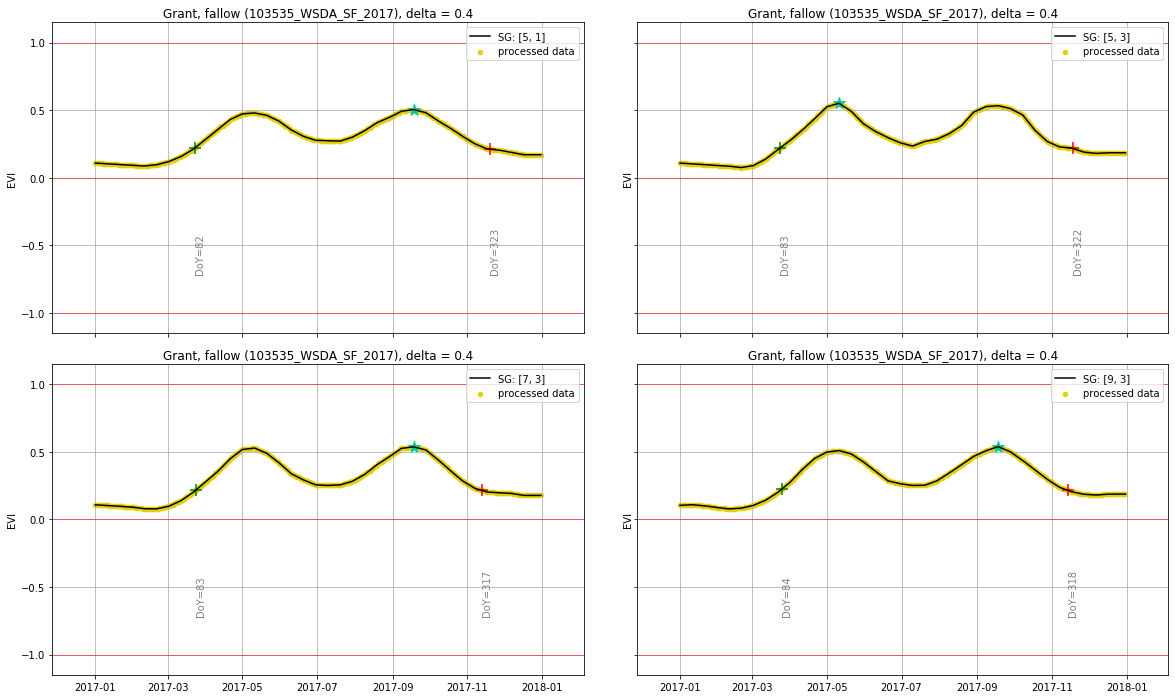

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(20,12),
                        sharex='col', sharey='row',
                        gridspec_kw={'hspace': 0.1, 'wspace': .1});

(ax1, ax2), (ax3, ax4) = axs;
ax1.grid(True); ax2.grid(True); ax3.grid(True); ax4.grid(True);

dataAB = curr_field
idx=indeks
SG_params=[5, 3]
SFYr = SF_year
ax=ax1
deltA= minFinderDetla
onset_cut = sos_thresh
offset_cut = eos_thresh



rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(dataAB = curr_field, 
                                                   idx=indeks, 
                                                   SG_params=[5, 1], 
                                                   SFYr = SF_year, ax=ax1, deltA= minFinderDetla,
                                                   onset_cut = sos_thresh, 
                                                   offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(dataAB = curr_field, 
                                           idx=indeks, SG_params=[5, 3], 
                                           SFYr=SF_year, ax=ax2, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh); 

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(dataAB = curr_field, 
                                           idx = indeks, SG_params=[7, 3],
                                           SFYr = SF_year, ax=ax3, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh);

rcp.SG_1yr_panels_clean_sciPy_My_Peaks_SOS_fineGranularity(dataAB = curr_field, 
                                           idx=indeks, SG_params=[9, 3],
                                           SFYr=SF_year, ax=ax4, deltA=minFinderDetla,
                                           onset_cut = sos_thresh, 
                                           offset_cut = eos_thresh)

'\ndistance : Required minimal horizontal distance (>= 1) in samples \n           between neighbouring peaks. Smaller peaks are removed first \n           until the condition is fulfilled for all remaining peaks.\n\nThis is gonna prevent detecting false peaks.\n'

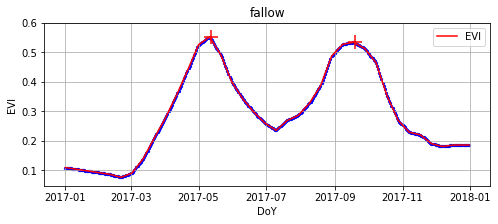

In [75]:
dataAB = curr_field
idx=indeks
SG_params=[5, 3]
SFYr = SF_year
ax=ax1
deltA= minFinderDetla,
onset_cut = sos_thresh 
offset_cut = eos_thresh

crr_fld = dataAB.copy()
if (not("human_system_start_time" in list(crr_fld.columns))):
    crr_fld = rc.add_human_start_time(crr_fld)

eleven_colors = ["gray", "lightcoral", "red", "peru",
                 "darkorange", "gold", "olive", "green",
                 "blue", "violet", "deepskyblue"]

plant = crr_fld['CropTyp'].unique()[0]
# Take care of names, replace "/" and "," and " " by "_"
plant = plant.replace("/", "_")
plant = plant.replace(",", "_")
plant = plant.replace(" ", "_")
plant = plant.replace("__", "_")

county = crr_fld['county'].unique()[0]
ID = crr_fld['ID'].unique()[0]

y = crr_fld[idx].copy()

#############################################
###
###             Smoothen
###
#############################################
# differences are minor, but lets keep using Pythons function
# my_savitzky_pred = rc.savitzky_golay(y, window_size=Sav_win_size, order=sav_order)
window_len = SG_params[0]
poly_order = SG_params[1]

SG_pred = scipy.signal.savgol_filter(y, window_length= window_len, polyorder=poly_order)

# SG might violate the boundaries. clip them:
SG_pred[SG_pred > 1 ] = 1
SG_pred[SG_pred < -1 ] = -1

crr_fld[idx] = SG_pred

#############################################
###
###             fine granularity table
###
#############################################
# create the full calenadr to make better estimation of SOS and EOS.
fine_granular_table = rc.create_calendar_table(SF_year = SFYr)
fine_granular_table = pd.merge(fine_granular_table, crr_fld, on=['Date', 'SF_year', 'doy'], how='left')

###### We need to fill the NAs that are created because they were not created in fine_granular_table
fine_granular_table["image_year"] = crr_fld["image_year"].unique()[0]
fine_granular_table["ID"]     = crr_fld["ID"].unique()[0]
fine_granular_table["Acres"]  = crr_fld["Acres"].unique()[0]
fine_granular_table["county"] = crr_fld["county"].unique()[0]

fine_granular_table["CropGrp"] = crr_fld["CropGrp"].unique()[0]
fine_granular_table["CropTyp"] = crr_fld["CropTyp"].unique()[0]
fine_granular_table["DataSrc"] = crr_fld["DataSrc"].unique()[0]
fine_granular_table["ExctAcr"] = crr_fld["ExctAcr"].unique()[0]

fine_granular_table["IntlSrD"] = crr_fld["IntlSrD"].unique()[0]
fine_granular_table["Irrigtn"] = crr_fld["Irrigtn"].unique()[0]

fine_granular_table["LstSrvD"] = crr_fld["LstSrvD"].unique()[0]
fine_granular_table["Notes"]   = crr_fld["Notes"].unique()[0]
fine_granular_table["RtCrpTy"] = crr_fld["RtCrpTy"].unique()[0]
fine_granular_table["Shap_Ar"] = crr_fld["Shap_Ar"].unique()[0]
fine_granular_table["Shp_Lng"] = crr_fld["Shp_Lng"].unique()[0]
fine_granular_table["TRS"] = crr_fld["TRS"].unique()[0]

fine_granular_table = rc.add_human_start_time_by_YearDoY(fine_granular_table)

# replace NAs with -1.5. Because, that is what the function fill_theGap_linearLine()
# uses as indicator for missing values
fine_granular_table.fillna(value={idx:-1.5}, inplace=True)

fine_granular_table = rc.fill_theGap_linearLine(regular_TS = fine_granular_table, 
                                                V_idx=idx, 
                                                SF_year=SFYr)

# update SG_pred so that we do not have to update too many other stuff.
SG_pred = fine_granular_table[idx].values.copy()
crr_fld = fine_granular_table
y = fine_granular_table[idx].copy()
#############################################
###
###   Form a data table of X and Y values
###
#############################################

if len(fine_granular_table['image_year'].unique()) == 2:
    X = rc.extract_XValues_of_2Yrs_TS(fine_granular_table, SF_yr = SFYr)
elif len(fine_granular_table['image_year'].unique()) == 1:
    X = fine_granular_table['doy']

d = {'DoY': X, 'Date': pd.to_datetime(fine_granular_table.human_system_start_time.values).values}
date_df = pd.DataFrame(data=d)

min_val_for_being_peak = 0.5

#############################################
###
###             find peaks scipy
###
#############################################
"""
distance : Required minimal horizontal distance (>= 1) in samples 
           between neighbouring peaks. Smaller peaks are removed first 
           until the condition is fulfilled for all remaining peaks.

This is gonna prevent detecting false peaks.
"""


# scipy.signal.argrelextrema(SG_pred, np.greater)
peaks_indxs, all_properties = scipy.signal.find_peaks(x = SG_pred, 
                                                      height = min_val_for_being_peak, 
                                                      threshold = None, 
                                                      distance = 3, #  
                                                      prominence = 0.2, 
                                                      width = 3, 
                                                      wlen = None, 
                                                      rel_height = 0.5, 
                                                      plateau_size=None)

scipy_SG_max_DoYs_series = X.iloc[peaks_indxs]
scipy_SG_max_series = pd.Series(all_properties['peak_heights'])


fig, ax = plt.subplots(figsize=(8,3));
plot_title = fine_granular_table.CropTyp.unique()[0]

ax.plot(fine_granular_table['Date'], fine_granular_table['EVI'], c='r', label="EVI")
ax.scatter(fine_granular_table['Date'], fine_granular_table['EVI'], marker='o', s=5, c='b')

# ax.scatter(np.array(scipy_SG_max_DoYs_series), np.array(scipy_SG_max_series), marker='o', s=25, c='b')
ax.scatter(fine_granular_table['Date'][scipy_SG_max_DoYs_series], scipy_SG_max_series, marker='+', s=200, c='r')

ax.set_title(plot_title);
ax.set(xlabel='DoY', ylabel='EVI')
ax.legend(loc="best");
ax.grid(True)

In [65]:
poly_order

1